In [1]:
import gymnasium as gym
import torch

In [2]:
env = gym.make("CartPole-v0")
n_state = env.observation_space.shape[0] 
n_action = env.action_space.n

/Users/arghasreebanerjee/opt/anaconda3/envs/XAI_week1/lib/python3.10/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


$S_i$ -> $S_i * W$ ->  Softmax (W->prob_action, Output of sigmoid = P)

In policy gradients, since you are taking the gradient of probabilty (softmax = P), applying log to the function and then taking the gradient smoothes the function. 

Instead of $\frac{\partial P}{\partial O}$, do $\frac{\partial \log (P)}{\partial O}$
$= \frac{\frac{\partial P}{\partial O}}{P} = \frac{(P-P^2)}{P}$

$S_i$ -> $\frac{\partial Softmax}{\partial (S_i * W)}$ <--$\frac{\partial Softmax}{\partial O}$ ($O = S_i * W$)

$\frac{\partial Softmax}{\partial (S_i * W)} = \frac{\partial Softmax}{\partial O} * \frac{\partial O}{\partial W} = (P-P^2) * S_i$


In [43]:
def run_episode(env, weight): 
    state = env.reset()[0]  
    grads = [] # new line for keeping track of the gradients 
    total_reward = 0
    is_done = False
    while not is_done:
        state = torch.from_numpy(state).float()
        multiply = torch.matmul(state, weight)
        
        # Instead of taking a deterministic action : action = torch.argmax(multiply), first compute the probability and then sample the action
        prob_action = torch.nn.Softmax()(multiply) # This step makes those action values into a probability distribution, for e.g. tensor([0.4957, 0.5043]) vs multiply = tensor([-0.0323, -0.0151])
        action = int(torch.bernoulli(prob_action[1]).item()) # bernoulli: Draws 1 if the prob is high, else draws 0, 
        # why the 1 is fixed? based on the probability of one of the actions, it is either chosen or not chosen. If prob[1] ~ action[1] is not chosen action[0] is chosen directly

        # Computing the gradient 
        d_softmax = torch.diag(prob_action) - prob_action.view(-1,1) * prob_action # As d_prob_action/d_multiply = p - p^2 = prob_action - prob_action^2
        '''
        For example:
        torch.diag(prob_action)= tensor([[0.5086, 0.0000],
                                         [0.0000, 0.4914]])

        prob_action.view(-1,1) = tensor([[0.4993],
                                        [0.5007]])
                                        
        prob_action = tensor([0.4993, 0.5007])

        prob_action.view(-1,1) * prob_action = tensor([[0.2449, 0.2500],
                                                        [0.2500, 0.2551]])
        '''
        d_log = d_softmax[action]/ prob_action[action] # See above for this step
        grad = state.view(-1,1)*d_log
        """
        grad = tensor([[-0.0093,  0.0093],
                        [-0.0066,  0.0066],
                        [-0.0065,  0.0065],
                        [ 0.0089, -0.0089]])
        """
        grads.append(grad)

        
        state, reward, is_done, _, info = env.step(action) # Instead of sampling the action from a uniform distribution directly, we assign weights and then sample in previous line
        total_reward += reward
        if is_done:
            break
    return total_reward, grads

$\theta = \theta + \nabla_\theta J$

$\nabla_\theta = \sum_{t}^{T} \nabla_\theta \log \pi R_t$

Here $R_t$ is the total reward - reward for earlier actions. \
And $t$ is the iteration at 1 episode 

In [44]:
weight = torch.rand(n_state, n_action)
total_rewards=[]
n_episode = 1000
learning_rate = 0.001

for episode in range(n_episode):
    reward, gradient = run_episode(env, weight)
    print(f'Episode {episode+1}: Rewards {reward}')
    """
    In an episode, for every action, there is some reward
    Instead of doing w=w-grad(w), as the gradient is not calculated based on the reward, this step has to be done differently.
    Gradient tells you the sensitivity of w on the softmax function, and reward tells you if the total/cummulative rewards received due to the action. 
    """
    for i, grad in enumerate(gradient):
        weight += learning_rate * grad * (reward - i) # (reward - i) is specific to this game, as reward is always 1
    total_rewards.append(reward)

/var/folders/1h/xvqz3pln3xl1h9vc7x7g49qw0000gn/T/ipykernel_80142/1730525670.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  prob_action = torch.nn.Softmax()(multiply) # This step makes those action values into a probability distribution, for e.g. tensor([0.4957, 0.5043]) vs multiply = tensor([-0.0323, -0.0151])


Episode 1: Rewards 13.0
Episode 2: Rewards 28.0
Episode 3: Rewards 22.0
Episode 4: Rewards 14.0
Episode 5: Rewards 35.0
Episode 6: Rewards 14.0
Episode 7: Rewards 41.0
Episode 8: Rewards 16.0
Episode 9: Rewards 17.0
Episode 10: Rewards 16.0
Episode 11: Rewards 20.0
Episode 12: Rewards 12.0
Episode 13: Rewards 29.0
Episode 14: Rewards 16.0
Episode 15: Rewards 12.0
Episode 16: Rewards 23.0
Episode 17: Rewards 15.0
Episode 18: Rewards 20.0
Episode 19: Rewards 14.0
Episode 20: Rewards 17.0
Episode 21: Rewards 24.0
Episode 22: Rewards 13.0
Episode 23: Rewards 12.0
Episode 24: Rewards 13.0
Episode 25: Rewards 16.0
Episode 26: Rewards 26.0
Episode 27: Rewards 30.0
Episode 28: Rewards 21.0
Episode 29: Rewards 14.0
Episode 30: Rewards 23.0
Episode 31: Rewards 19.0
Episode 32: Rewards 14.0
Episode 33: Rewards 51.0
Episode 34: Rewards 15.0
Episode 35: Rewards 16.0
Episode 36: Rewards 18.0
Episode 37: Rewards 18.0
Episode 38: Rewards 15.0
Episode 39: Rewards 23.0
Episode 40: Rewards 30.0
Episode 4

In [45]:
print(f'Average rewards = {sum(total_rewards)/n_episode}')

Average rewards = 44.782


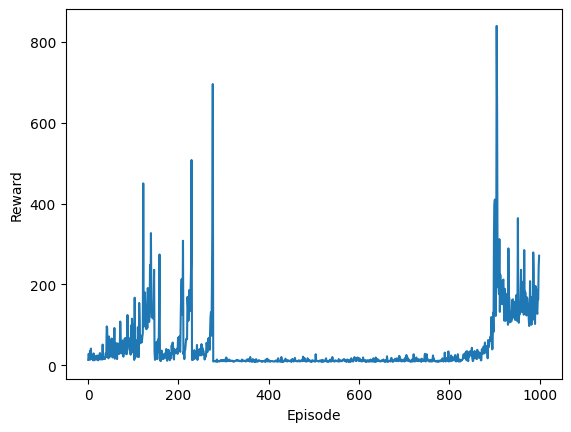

In [46]:
import matplotlib.pyplot as plt

plt.plot(total_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()

# Monte Carlo policy gradient 
Here you update the weights based on the gradient computed on the total rewards on an episode. \
As you wait for the entire episode to get over, this method is called *Monte Carlo policy gradient*.